# K近邻法

## 一、基本概念

1．$k$近邻法是基本且简单的分类与回归方法。

$k$近邻法的基本做法是：对给定的训练实例点和输入实例点，首先确定输入实例点的$k$个最近邻训练实例点，然后利用这$k$个训练实例点的类的多数来预测输入实例点的类。

2．$k$近邻模型对应于基于训练数据集对特征空间的一个划分。$k$近邻法中，当训练集、距离度量、$k$值及分类决策规则确定后，其结果唯一确定。

3．$k$近邻法三要素：距离度量、$k$值的选择和分类决策规则。

- 常用的距离度量是欧氏距离及更一般的**$L_p$**距离。
- $k$值小时，$k$近邻模型更复杂；$k$值大时，$k$近邻模型更简单。
- $k$值的选择反映了对近似误差与估计误差之间的权衡，通常由交叉验证选择最优的$k$。

**常用的分类决策规则是多数表决，对应于经验风险最小化。**

4．$k$近邻法的实现需要考虑如何快速搜索k个最近邻点。

- **kd**树是一种便于对k维空间中的数据进行快速检索的数据结构。

- kd树是二叉树，表示对$k$维空间的一个划分，其每个结点对应于$k$维空间划分中的一个超矩形区域。

- 利用**kd**树可以省去对大部分数据点的搜索， 从而减少搜索的计算量。

## 二、距离度量

设特征空间$x$是$n$维实数向量空间 ，$x_{i}, x_{j} \in \mathcal{X}$,$x_{i}=\left(x_{i}^{(1)}, x_{i}^{(2)}, \cdots, x_{i}^{(n)}\right)^{\mathrm{T}}$,$x_{j}=\left(x_{j}^{(1)}, x_{j}^{(2)}, \cdots, x_{j}^{(n)}\right)^{\mathrm{T}}$
，则：$x_i$,$x_j$的$L_p$距离定义为:


$$
L_{p}\left(x_{i}, x_{j}\right)=\left(\sum_{i=1}^{n}\left|x_{i}^{(i)}-x_{j}^{(l)}\right|^{p}\right)^{\frac{1}{p}}
$$

- $p= 1$  曼哈顿距离
- $p= 2$  欧氏距离
- $p= \infty$   切比雪夫距离

In [55]:
import math
from itertools import combinations

In [56]:
# math.pow(a,b): a是底数，b是指数

def L(x, y, p=2):
    if len(x) == len(y) and len(x) > 1:
        sum = 0
        for i in range(len(x)):
            sum += math.pow(abs(x[i] - y[i]), p)
        return math.pow(sum, 1/p)
    else:
        return 0

In [57]:
# 例题-3.1

x1 = [1,1]
x2 = [5,1]
x3 = [4,4]

for i in range(1,5):
    r = {'1-{}'.format(c): L(x1, c, p=i) for c in [x2, x3]}
    print(r)
    print(min(zip(r.values(), r.keys())))  # zip([4,6],[1-[5,1], 1-[4,4]]) = [(4,1-[5,1]), (6,1-[4,4])]

{'1-[5, 1]': 4.0, '1-[4, 4]': 6.0}
(4.0, '1-[5, 1]')
{'1-[5, 1]': 4.0, '1-[4, 4]': 4.242640687119285}
(4.0, '1-[5, 1]')
{'1-[5, 1]': 3.9999999999999996, '1-[4, 4]': 3.7797631496846193}
(3.7797631496846193, '1-[4, 4]')
{'1-[5, 1]': 4.0, '1-[4, 4]': 3.5676213450081633}
(3.5676213450081633, '1-[4, 4]')


In [23]:
a = [1,2,3]
b = [4,5,6]
c = [4,5,6,7,8]
zipped = zip(a,c)  
list(zipped)

[(1, 4), (2, 5), (3, 6)]

## 三、算法实现

遍历所有数据点，找出$n$个距离最近的点的分类情况，少数服从多数

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter

In [9]:
# data
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length','sepal width','petal length','petal width','label']

In [10]:
df.head()

,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


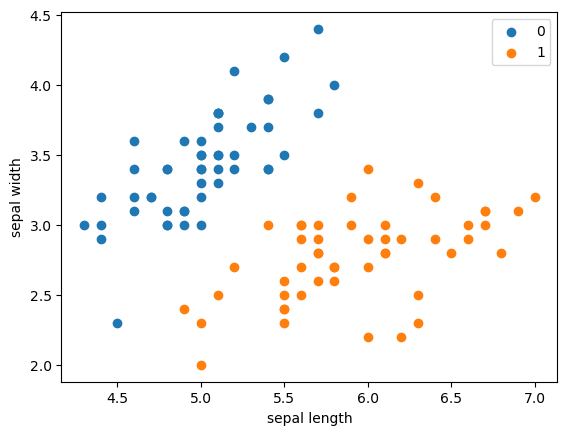

In [11]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [12]:
data = np.array(df.iloc[:100, [0,1,-1]])
X, y = data[:,:-1], data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("There are {} train samples".format(y_train.shape[0]))
print("There are {} test samples".format(y_test.shape[0]))

There are 80 train samples
There are 20 test samples


In [13]:
class KNN:
    def __init__(self, X_train, y_train, n_neighbors=3, p=2):
        """
        parameter: n_neighbors 临近点个数
        parameter: p 距离度量
        """
        self.X_train = X_train
        self.y_train = y_train
        self.n = n_neighbors
        self.p = p
        
    def predict(self, X):
        # 取出n个点
        knn_list = []
        for i in range(self.n):
            dist = np.linalg.norm(X - X_train[i], ord=self.p)  # 求L范数
            knn_list.append((dist, y_train[i]))
        
        for i in range(self.n, len(X_train)):
            """
            循环判断剩下的点和X的距离，如果距离比目前的最大值小，则替换最大值，再次排序，依次进行
            """
            max_index = knn_list.index(max(knn_list, key = lambda x:x[0]))
            dist = np.linalg.norm(X - X_train[i], ord=self.p)
            if knn_list[max_index][0] > dist:
                knn_list[max_index] = (dist, self.y_train[i])
        
        # 统计
        knn = [k[-1] for k in knn_list]
        count_pairs = Counter(knn)
        max_count = sorted(count_pairs.items(), key=lambda x: x[1])[-1][0]
        return max_count
    
    def score(self, X_test, y_test):
        right_count = 0
        n = 10
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            if label == y:
                right_count += 1
        return right_count/len(X_test)

In [14]:
test_point = [6.0 ,3.0]
clf = KNN(X_train, y_train)

print('Test Point: {}'.format(clf.predict(test_point)))
print('Score: {}'.format(clf.score(X_test, y_test)))

Test Point: 1.0
Score: 1.0


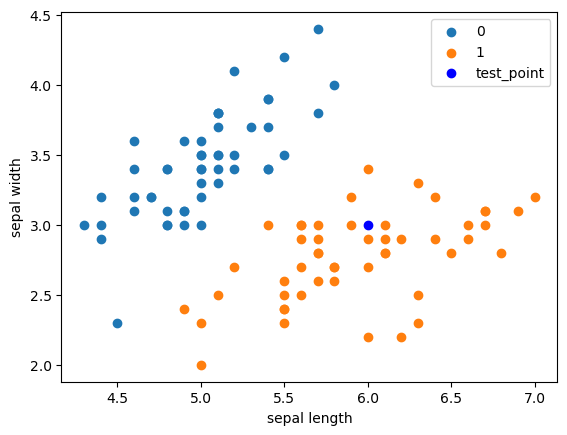

In [15]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.plot(test_point[0], test_point[1], 'bo', label='test_point')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

## 四、构造kd树

### 基本概念

**kd**树是一种对k维空间中的实例点进行存储以便对其进行快速检索的树形数据结构。

**kd**树是二叉树，表示对$k$维空间的一个划分（partition）。构造**kd**树相当于不断地用垂直于坐标轴的超平面将$k$维空间切分，构成一系列的k维超矩形区域。kd树的每个结点对应于一个$k$维超矩形区域。

构造**kd**树的方法如下：

- 构造根结点，使根结点对应于$k$维空间中包含所有实例点的超矩形区域；通过下面的递归方法，不断地对$k$维空间进行切分，生成子结点。在超矩形区域（结点）上选择一个坐标轴和在此坐标轴上的一个切分点，确定一个超平面，这个超平面通过选定的切分点并垂直于选定的坐标轴，将当前超矩形区域切分为左右两个子区域（子结点）；这时，实例被分到两个子区域。这个过程直到子区域内没有实例时终止（终止时的结点为叶结点）。在此过程中，将实例保存在相应的结点上。

- 通常，依次选择坐标轴对空间切分，选择训练实例点在选定坐标轴上的中位数（median）为切分点，这样得到的**kd**树是平衡的。注意，平衡的**kd**树搜索时的效率未必是最优的。


### 构造平衡kd树算法

输入：$k$维空间数据集$T＝\{x_1，x_2,…,x_N\}$，

其中$x_{i}=\left(x_{i}^{(1)}, x_{i}^{(2)}, \cdots, x_{i}^{(k)}\right)^{\mathrm{T}}$ ，$i＝1,2,…,N$；

输出：**kd**树。

（1）开始：构造根结点，根结点对应于包含$T$的$k$维空间的超矩形区域。

- 选择$x^{(1)}$为坐标轴，以T中所有实例的$x^{(1)}$坐标的中位数为切分点，将根结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。

- 由根结点生成深度为1的左、右子结点：左子结点对应坐标$x^{(1)}$小于切分点的子区域， 右子结点对应于坐标$x^{(1)}$大于切分点的子区域。

- 将落在切分超平面上的实例点保存在根结点。

（2）重复：对深度为$j$的结点，选择$x^{(1)}$为切分的坐标轴，$l＝j(mod {\,} k)+1$，以该结点的区域中所有实例的$x^{(1)}$坐标的中位数为切分点，将该结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。

- 由该结点生成深度为$j+1$的左、右子结点：左子结点对应坐标$x^{(1)}$小于切分点的子区域，右子结点对应坐标$x^{(1)}$大于切分点的子区域。

- 将落在切分超平面上的实例点保存在该结点。

（3）直到两个子区域没有实例存在时停止。从而形成**kd**树的区域划分。

In [73]:
# kd-tree每个结点中主要包含的数据结构如下
class KdNode(object):
    def __init__(self, dom_elt, split, left, right):
        self.dom_elt = dom_elt  # k维向量节点（k维空间中的一个样本点）
        self.split = split      # 整数（进行分割维度的序号）
        self.left = left        # 该结点分割超平面左子空间构成的kd-tree
        self.right = right      # 该结点分割超平面右子空间构成的kd-tree
        
class KdTree(object):
    def __init__(self, data_set):    
        k = len(data[0])    # 获取数据的维度
    
        def CreateNode(split, data_set):  # 按第split维划分数据集exset创建KdNode
            if not data_set:
                return None
            data_set.sort(key = lambda x:x[split])   # 按照选择的split维度排序
            split_pos = len(data_set) //2    # 取中位数
            median = data_set[split_pos]     # 中位数分割点作为根节点
            split_next = (split + 1) % k     # 循环选择分割的维度，也就是各个维度轮流
            
            # 递归的创建kd树
            return KdNode(
                median,
                split,
                CreateNode(split_next, data_set[:split_pos]),      # 创建左子树
                CreateNode(split_next, data_set[split_pos + 1 :])  # 创建右子树
            )
        
        self.root = CreateNode(0, data)  # 从第0维分量开始构建kd树,返回根节点

# KDTree的前序遍历
def preorder(root):
    print(root.dom_elt)  
    if root.left:    # 节点不为空
        preorder(root.left)
    if root.right:
        preorder(root.right)

In [89]:
# 对构建好的kd树进行搜索，寻找与目标点最近的样本点：
from math import sqrt
from collections import namedtuple

# 定义一个namedtuple,分别存放最近坐标点、最近距离和访问过的节点数
result = namedtuple("Result_tuple",
                    "nearest_point  nearest_dist  nodes_visited")

def find_nearest(tree, point):
    k = len(point)    # 数据维度
    
    def travel(kd_node, target, max_dist):
        if kd_node is None:
            return result([0] * k, float("inf"),0)  # python中用float("inf")和float("-inf")表示正负无穷
        
        nodes_visited = 1
        
        s = kd_node.split     # 进行分割的维度
        pivot = kd_node.dom_elt     # 进行分割的轴
        
        if target[s] <= pivot[s]:     # 如果目标点第s维小于分割轴的对应值(目标离左子树更近)
            nearer_node = kd_node.left    # 下一个访问节点为左子树根节点
            further_node = kd_node.right   # 同时记录下右子树
        else:
            nearer_node = kd_node.right    # 下一个访问节点为右子树根节点
            further_node = kd_node.left   # 同时记录下左子树
            
        temp1 = travel(nearer_node, target, max_dist)
        
        nearest = temp1.nearest_point    # 以此叶结点作为“当前最近点”
        dist = temp1.nearest_dist  # 更新最近距离
        
        nodes_visited += temp1.nodes_visited
        
        if dist < max_dist:
            max_dist = dist  # 最近点将在以目标点为球心，max_dist为半径的超球体内
        
        temp_dist = abs(pivot[s] - target[s])   # 第s维上目标点与分割超平面的距离
        if max_dist < temp_dist:      # 判断超球体是否与超平面相交
            return result(nearest, dist, nodes_visited)  # 不相交则可以直接返回，不用继续判断
        
         #----------------------------------------------------------------------
        # 计算目标点与分割点的欧氏距离
        temp_dist = sqrt(sum((p1 - p2)**2 for p1,p2 in zip(pivot, target)))
        
        if temp_dist < dist:  # 如果“更近”
            nearest = pivot  # 更新最近点
            dist = temp_dist  # 更新最近距离
            max_dist = dist  # 更新超球体半径
            
        # 检查另一个子结点对应的区域是否有更近的点
        temp2 = travel(further_node, target, max_dist)

        nodes_visited += temp2.nodes_visited
        if temp2.nearest_dist < dist:  # 如果另一个子结点内存在更近距离
            nearest = temp2.nearest_point  # 更新最近点
            dist = temp2.nearest_dist  # 更新最近距离

        return result(nearest, dist, nodes_visited)

    return travel(tree.root, point, float("inf"))  # 从根节点开始递归

In [90]:
# 例题-3.2

data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = KdTree(data)
preorder(kd.root)

[7, 2]
[5, 4]
[2, 3]
[4, 7]
[9, 6]
[8, 1]


In [91]:
from time import perf_counter
from random import random

# 产生一个k维随机向量，每维分量值在0~1之间
def random_point(k):
    return [random() for _ in range(k)]
 
# 产生n个k维随机向量 
def random_points(k, n):
    return [random_point(k) for _ in range(n)]  

In [92]:
ret = find_nearest(kd, [3,4.5])
print (ret)

Result_tuple(nearest_point=[2, 3], nearest_dist=1.8027756377319946, nodes_visited=4)


In [93]:
N = 400000
t0 = perf_counter()
kd2 = KdTree(random_points(3, N))            # 构建包含四十万个3维空间样本点的kd树
ret2 = find_nearest(kd2, [0.1,0.5,0.8])      # 四十万个样本点中寻找离目标最近的点
t1 = perf_counter()
print ("time: ",t1-t0, "s")
print (ret2)

time:  1.7346821000101045 s
Result_tuple(nearest_point=[2, 3], nearest_dist=3.1400636936215163, nodes_visited=3)


## 五、习题

### 习题-3.1

参照图3.1，在二维空间中给出实例点，画出 𝑘 为1和2时的 𝑘 近邻法构成的空间划分，并对其进行比较，体会 𝑘 值选择与模型复杂度及预测准确率的关系。

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap 

In [8]:
data = np.array([[5, 12, 1], [6, 21, 0], [14, 5, 0], [16, 10, 0], [13, 19, 0],
                 [13, 32, 1], [17, 27, 1], [18, 24, 1], [20, 20,0], [23, 14, 1],
                 [23, 25, 1], [23, 31, 1], [26, 8, 0], [30, 17, 1],
                 [30, 26, 1], [34, 8, 0], [34, 19, 1], [37, 28, 1]])
X_train = data[:, 0:2]
y_train = data[:, 2]

models = (
    KNeighborsClassifier(n_neighbors=1, n_jobs=-1),
    KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
)
models = (clf.fit(X_train,y_train) for clf in models)

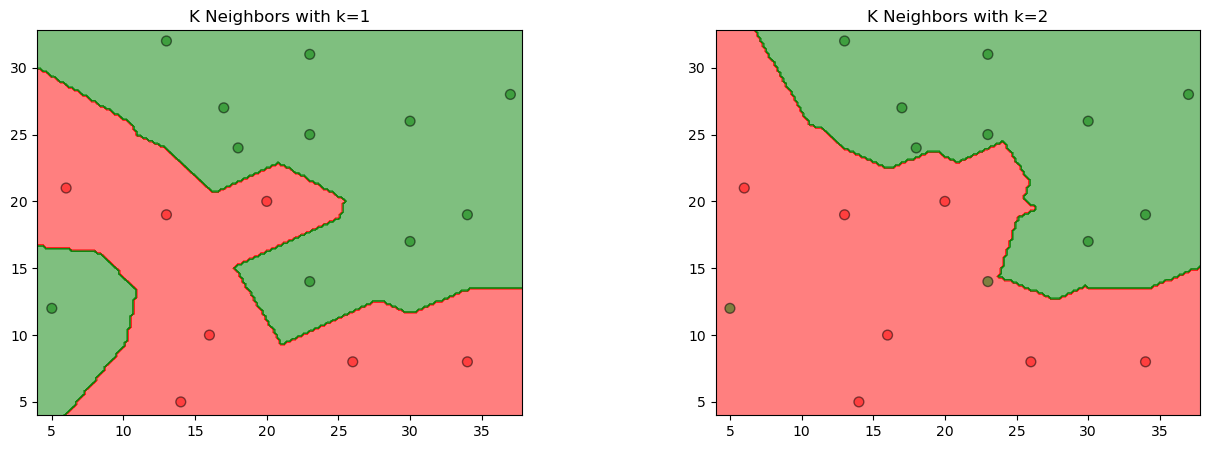

In [11]:
titles = ('K Neighbors with k=1', 'K Neighbors with k=2')

fig = plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_train[:, 0], X_train[:, 1] 
x_min, x_max = X0.min() - 1, X0.max() + 1
y_min, y_max = X1.min() - 1, X1.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2), np.arange(y_min, y_max, 0.2))

for clf, title, ax in zip(models, titles, fig.subplots(1, 2).flatten()):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    colors = ('red', 'green', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(Z))])
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)
    ax.scatter(X0, X1, c=y_train, s=50, edgecolors='k', cmap=cmap, alpha=0.5)
    ax.set_title(title)

plt.show()